In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter as sgf
from math import factorial as fact

df = pd.read_csv("Scan CSV Files/Water_test6.csv")
df.drop("Unnamed: 0", axis = 1, inplace=True)
df.set_index("Wavelengths", inplace=True)
df.head()

In [16]:
diff = []

for i in df.columns:
    first = list(df['397.0'])
    compare = list(df[i])
    diff.append(sum([abs(i-j) for i,j in zip(first, compare)]))

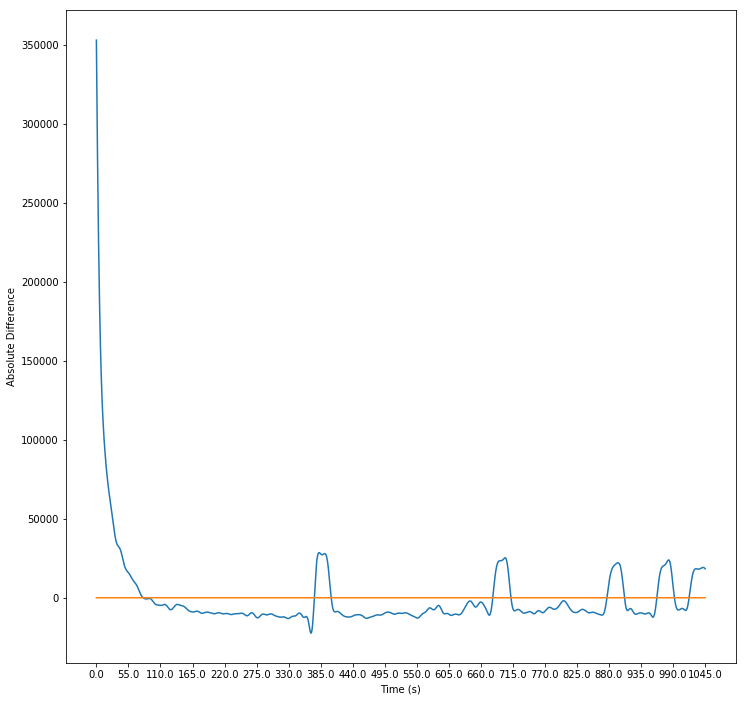

In [23]:
%matplotlib inline

avg = np.average(diff)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, ylabel="Absolute Difference", xlabel="Time (s)")

ax.set_xticks(np.linspace(float(df.columns[0]), float(df.columns[-1])*2, 20))
ax.set_xticklabels([i for i in df.columns if float(i)%int(len(df.columns)/40) == 0])

diff = sgf(diff, window_length=31, polyorder=3)
ax.plot(list(df.columns), diff-avg)
ax.plot(list(df.columns), [0 for i in df.columns])

In [13]:
[i for i in df.columns[2:] if float(i)%int(len(df.columns[2:])/10) == 0]

df['700.0'].plot(color="r")
df['397.0'].plot(color='b')
df['0.0'].plot(color='g')

# Identifying Threshold

Plotting SAD vs Window length
* Take the absolute difference curve. Smooth it out, and see what the absolute difference is.

In [162]:
diff = [] # List with the SAD

# Calculating the differences
for i in df.columns:
    first = list(df['0.0']) # Compare with first spectrum
    compare = list(df[i])
    diff.append(sum([abs(i-j) for i,j in zip(first, compare)]))

def N_opt(diff, L = len(diff), n=3):
    n = 3
    term1 = (2*(n+2) * (fact(2*n+3))**2)/(fact(n+1))**2

    vn = 1/L * sum(np.diff(diff,n+2)**2)
    var = np.var(diff)**2

    Nopt = (term1*var/vn)**(1/(2*n+5))
    
    return int(np.ceil(Nopt) // 2 * 2 + 1)

# Spectrum for calculating threshold
diff_1 = sgf(diff, window_length=N_opt(diff), polyorder=3)

change = [i - j for i,j in zip(diff_1[:-2], diff_1[1:])] # gives the incremental difference between data points.
change = sgf(change, window_length=301, polyorder=3)

j_old = 0
eps = []
for i,j in enumerate(change):
    if i != 0: 
        perc_diff = abs(j-j_old)/abs((j+j_old)/2) * 100
        if perc_diff < 1 : 
            eps.append(i)
    j_old = j

print(eps)

eps = change[eps[0]] # will give you the x value that it occurs

# plt.tick_params(left=True, labelleft=True)
# plt.plot(df.columns[1:-1], change)
# plt.plot(df.columns[1:-1], [0 for i in df.columns[1:-1]])
# plt.plot(df.columns[1:-1], [eps for i in df.columns[1:-1]])


[119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 171, 172, 175, 176, 178, 179, 180, 183, 184, 185, 186, 187, 191, 197, 198, 199, 201, 202, 204, 205, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 220, 221, 222, 228, 237, 239, 243, 247, 248, 249, 256, 257, 259, 260, 261, 276, 278, 279, 280, 283, 284, 285, 292, 294, 302, 304, 306, 307, 308, 309, 311, 316, 319, 320, 321, 323, 327, 329, 330, 334, 335, 337, 342, 347, 348, 350, 351, 352, 355, 357, 359, 360, 366, 367, 368, 370, 371, 373, 374, 378, 380, 383, 384, 387, 390, 392, 394, 395, 397, 398, 399, 402, 413, 415, 417, 423, 424, 425, 428, 431, 433, 437, 439, 443, 445, 446, 449, 454, 459, 463, 467, 470, 471, 473, 477, 479, 482, 484, 492, 502, 503, 509, 511, 512, 519, 521, 522, 524, 527, 528, 529, 532, 537, 539, 540, 541, 543, 549, 550, 554, 559, 565, 570, 572, 574, 576, 577, 578, 579, 580, 581, 582, 588, 589, 592, 595, 602, 603, 607, 609, 611, 612, 616, 617, 618, 629, 657, 658, 659, 660, 661, 725, 726, 727, 728,

In [262]:
from rdp import rdp

sec_deriv = sgf(change, window_length=101, polyorder=3, deriv=2)
# plt.plot(sec_deriv)

# plt.plot(abs(sec_deriv) < 0.2)

def steady_state(seq, n=30, eps=0.2):
    seq = abs(seq) < eps
    for i in range(len(seq)):
        win = seq[i:i+n]
        if sum(win) == 30:
            return i
steady_state(sec_deriv)

201